# BUSINESS UNDERSTANDING

## PROJECT OVERVIEW

Breast cancer remains one of the leading cause of cancer related deaths among women worldwide, making early and accurate detection is crucial for better outcomes.
Manual examination of histopathological images is labor intensive, subjective, and prone to human error.

Deep learning particularly CNNs offers a way to automate and improve this process. By analyzing microscopic breast tissue images CNN models can deliver faster, more consistent, and highly accurate classifications.
This part of the project focuses on building an interpretable AI model that can distinguish benign and malignant samples at 100X magnification and assist in making quicker and reliable diagnostic decisions.

## PROBLEM STATEMENT

Breast cancer diagnosis from histopathology images is traditionally performed manually by pathologists. This process is:
* Time-consuming
* Prone to human error
* Dependent on specialist skill


There is a need for an intelligent system that can classify breast tissue images accurately and consistently, helping detect malignancies(cancerous cells) at an early stage.

The goal of this project is to build a classifier that distinguishes benign vs malignant breast cancer images using the BreakHis dataset, supporting faster and more reliable diagnosis.

# BUSINESS OBJECTIVE

* The main objective is to develop an image classification system, built using deep learning, that accurately distinguishes between **benign** and **malignant** histopathological images 
using the BreakHis dataset

**Specific Objectives**
* Data Preparation: To preprocess and analyze the BreakHis dataset, ensuring high-quality, standardized images suitable for training a deep learning model.
* Model Development: To design and train a Convolutional Neural Network (CNN) capable of accurately learning distinguishing features between benign and malignant breast tissue.
* Model Evaluation: To assess the performance of the model using metrics such as accuracy, precision, recall, and F1-score 
* Deployment : To deploy the trained model as a user friendly system for real time image classification

# RESEARCH QUESTIONS

1. Can a CNN model accurately classify histopathological breast tissue images into benign and malignant categories?
2. How does class imbalance affect model performance, and which strategies are most effective in handling it?
3. How much does data augmentation improve accuracy and prevent overfitting?
5. Can this automated system support early diagnosis and reduce human error in image-based cancer classification?
6. How can the trained model be deployed as a web-based tool for clinical use?


# DATA UNDERSTANDING

## DATA OVERVIEW

The dataset used in this study is the BreakHis **(Breast Cancer Histopathological Database)**, a publicly available collection of microscopic breast tissue images designed to support research in breast cancer diagnosis using image processing and machine learning.
It contains histopathological images of both benign and malignant tumors, captured at multiple magnification levels (40×, 100×, 200×, and 400×). Each image is labeled according to its tumor class (benign or malignant).


In [1]:
# Importing required libraries

import os
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import hashlib
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau



* **We will perform binary image classification using 100X magnification images, excluding 40X, 200X, and 400X to avoid redundancy duplication of the same image at different magnification.**

**Steps**
* Load the Dataset to the path of 100X magnification.
* Count images in each class.
* Check for any duplicates and corrupted images
* Split the dataset, 70% for training, 30% for validation/test
* Handle Class imbalance
* Prepare training images with rescaling(normalization) + augmentation.
* Prepare validation/test images with rescaling only.
* Build the classifier models

### **Load The Dataset**

In [2]:
# Path to our dataset folder
dataset_path = "data/dataset_cancer_v1/classificacao_binaria/100X"

# Load dataset using TensorFlow
data = tf.keras.utils.image_dataset_from_directory(
    dataset_path,   
    batch_size=32,
    image_size=(224, 224),
    shuffle=True
)

# Show class names
print("Classes found:")
print(data.class_names)


Found 2081 files belonging to 2 classes.
Classes found:
['benign', 'malignant']


### **Count Images in each Class**

In [3]:
# Path to 100X dataset
dataset_path = "data/dataset_cancer_v1/classificacao_binaria/100X"

# Get class names
classes = sorted(os.listdir(dataset_path))

# Count images in each class
print("Class Counts:\n")
for class_name in classes:
    class_dir = os.path.join(dataset_path, class_name)
    count = len(os.listdir(class_dir))
    print(f"{class_name}: {count} images")

Class Counts:

benign: 644 images
malignant: 1437 images


* **The classes distribution is imbalanced with malignant images more than the benign ones**

### **Checking for duplicates**

In [4]:
def count_duplicates(dataset):
    seen = set()
    duplicates = 0
    total = 0

    for images, _ in dataset:
        for img in images:
            img_hash = hashlib.md5(img.numpy().tobytes()).hexdigest()
            if img_hash in seen:
                duplicates += 1
            else:
                seen.add(img_hash)
            total += 1
        

    print(f"\nTotal images checked: {total}")
    print(f"Unique images: {len(seen)}")
    print(f"Duplicate images: {duplicates}")

# Using the function
count_duplicates(data)


Total images checked: 2081
Unique images: 2048
Duplicate images: 33


* **33 duplicates identified which will be removed before training to prevent any bias in the model performance**  

### **Checking for Corrupt Images**

In [5]:
# Path of the dataset
dataset_path = "data/dataset_cancer_v1/classificacao_binaria/100X"
classes = ['benign', 'malignant']

# Initialize list to store corrupted images
corrupted_images = []

for c in classes:
    class_path = os.path.join(dataset_path, c)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path)
            img.verify() 
        except Exception:
            corrupted_images.append(img_path)

print(f"Total corrupted images found: {len(corrupted_images)}")
if corrupted_images:
    print("Some images are corrupted. Example:")
    print(corrupted_images[:5])
else:
    print("No corrupted images found.")

Total corrupted images found: 0
No corrupted images found.


### **Remove duplicated images**

In [6]:
# Remove duplicates and create new cleaned folder 
               
dataset_path = "data/dataset_cancer_v1/classificacao_binaria/100X"
clean_data_path = "data/dataset_cancer_v1/classificacao_binaria/100X_clean"
classes = ['benign', 'malignant']
seen = set()

for c in classes:
    os.makedirs(os.path.join(clean_data_path, c), exist_ok=True)
    
    for img_name in os.listdir(os.path.join(dataset_path, c)):
        img_path = os.path.join(dataset_path, c, img_name)

        try:
            img = Image.open(img_path)
            img_hash = hashlib.md5(img.tobytes()).hexdigest()
            if img_hash not in seen:
                seen.add(img_hash)
                
                # save the image as it is
                img.save(os.path.join(clean_data_path, c, img_name))
        except Exception as e:
            print(f"Error: processing {img_path}: {e}")

print("Duplicates removed, unique images saved in clean data path")                 

Duplicates removed, unique images saved in clean data path


In [7]:
# Confirm if the duplicates were succesfully removed

clean_data_path = "data/dataset_cancer_v1/classificacao_binaria/100X_clean"
seen, duplicates, total = set(), 0, 0

for c in ['benign', 'malignant']:
    for f in os.listdir(os.path.join(clean_data_path, c)):
        img = Image.open(os.path.join(clean_data_path, c, f))
        h = hashlib.md5(img.tobytes()).hexdigest()
        duplicates += h in seen
        seen.add(h)
        total += 1

print(f"Total: {total}\nUnique: {len(seen)}\nDuplicates: {duplicates}")

Total: 2048
Unique: 2048
Duplicates: 0


### **Splitting the data**

In [8]:
clean_data_path = "data/dataset_cancer_v1/classificacao_binaria/100X_clean"

# Training dataset (70%) 
train_dataset = tf.keras.utils.image_dataset_from_directory(
    clean_data_path,
    validation_split=0.3,     # Reserve 30% for validation
    subset="training",
    seed=42,                  # Ensures reproducibility
    image_size=(224, 224),
    batch_size=32,          # Number of images processed by the model before updating weights
    #shuffle=True
    color_mode = "rgb"
)

# Validation dataset (30%)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    clean_data_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=(224, 224),
    batch_size=32,
    #shuffle=True
    color_mode = "rgb"
)

# 
val_batches = tf.data.experimental.cardinality(val_dataset)
val_dataset = val_dataset.take(val_batches // 2)
test_dataset = val_dataset.skip(val_batches // 2)



Found 2048 files belonging to 2 classes.
Using 1434 files for training.
Found 2048 files belonging to 2 classes.
Using 614 files for validation.


#### **Visualize a few samples to confirm everything worked well**

Training samples:


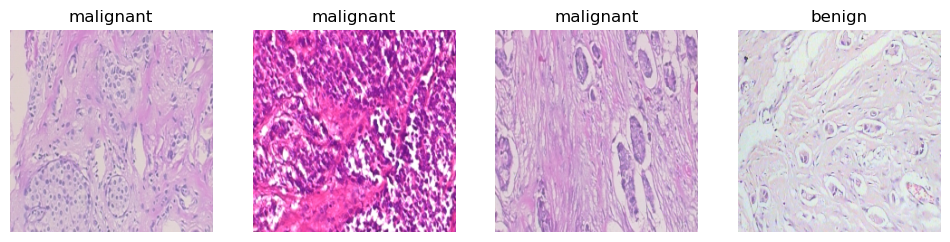

Validation samples:


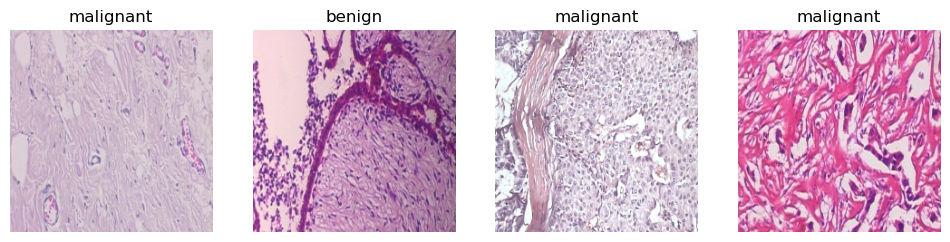

In [9]:
# Function to show a batch of images
def show_samples(dataset, class_names, n=4):
    for images, labels in dataset.take(1):  # Take 1 batch
        plt.figure(figsize=(12,4))
        for i in range(n):
            plt.subplot(1, n, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
        plt.show()

# Visualize training samples
print("Training samples:")
show_samples(train_dataset, train_dataset.class_names)

# Visualize validation samples
print("Validation samples:")
show_samples(val_dataset, train_dataset.class_names)

### **Data Augmentation to Training Dataset**

In [10]:
# Create data augmentation, data augmentation improves generalization
data_augmentation = tf.keras.Sequential([                 
    layers.RandomFlip("horizontal_and_vertical"),    # Random Flip
    layers.RandomRotation(0.1),                     # Randomly rotates images by a fraction of 0.1, Prevents the model from overfitting to one fixed orientation
    layers.RandomZoom(0.1),                         # Random Zoom
])

# Apply augmentation to the whole training dataset
train_dataset_augmented = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


### **Handling Class Imbalance**

In [11]:
benign = 644
malignant = 1437
total = benign + malignant

weight_for_0 = (1/ benign) * (total/2)         # Benign has fewer samples so it gets higher weights
weight_for_1 = (1/malignant) * (total/2)      # Malignant has more samples so it gets lower weights

# Boost malignant so model focuses on catching cancerous cells
boost = 1.6

weight_for_1 = weight_for_1 * boost

class_weights = {0: weight_for_0, 1:weight_for_1}
print(class_weights)

{0: 1.6156832298136645, 1: 1.158524704244955}


In [12]:
print(train_dataset.class_names)

['benign', 'malignant']


### **Normalization**

In [13]:
# Normalize augmented training dataset
train_dataset_augmented = train_dataset_augmented.map(lambda x, y: (x / 255.0, y))

# Normalize validation dataset 
validation_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))

* **The pixels are scaled/normalised to [0,1] which help gradient descent converge faster and prevent vanishing gradients**

## **MODELING**

### **Convolutional Neaural Network for binary classification**

In [14]:
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras import regularizers

l2_reg = regularizers.l2(0.005)                                   # l2 penalty to help in stability and prevent overfitting

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# CNN architecture
model = Sequential([
     
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer = l2_reg, input_shape=(224, 224, 3)),
    #BatchNormalization(),                                            # stabilizes the model, speed up training, allow higher learning rates
    MaxPooling2D(),
                                              
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer = l2_reg),
   # BatchNormalization(), 
    MaxPooling2D(),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer = l2_reg),
    #BatchNormalization(), 
    MaxPooling2D(),
    
    GlobalAveragePooling2D(),
    
    # Dense Layers
    Dense(128, activation='relu', kernel_regularizer = l2_reg),
    Dropout(0.4),
    
    # Output
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'Recall']
)

model.summary()


C:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,889 (429.25 KB)

 Trainable params: 109,889 (429.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Callbacks
# stops training automatically when the model stops improving
early_stop = EarlyStopping(
    monitor='val_Recall',   
    #mode='max',
    patience=4,
    restore_best_weights=True
)


early_stop = EarlyStopping(
    monitor='val_precision',   
    patience=4,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset_augmented,
    validation_data=validation_dataset,
    epochs=20,
    class_weight= class_weights,
    callbacks=[early_stop]
)

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - Recall: 0.9720 - accuracy: 0.6646 - loss: 2.1169 - precision: 0.6739 - val_Recall: 1.0000 - val_accuracy: 0.7031 - val_loss: 1.7902 - val_precision: 0.7031
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - Recall: 0.9948 - accuracy: 0.6785 - loss: 1.9719 - precision: 0.6780 - val_Recall: 1.0000 - val_accuracy: 0.7250 - val_loss: 1.6401 - val_precision: 0.7250
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - Recall: 0.9948 - accuracy: 0.6897 - loss: 1.8264 - precision: 0.6857 - val_Recall: 1.0000 - val_accuracy: 0.7250 - val_loss: 1.5048 - val_precision: 0.7250
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - Recall: 0.9492 - accuracy: 0.7448 - loss: 1.6912 - precision: 0.7429 - val_Recall: 1.0000 - val_accuracy: 0.7312 - val_loss: 1.3704 - val_precision: 0.7304
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - Recall: 0.8694 - accuracy: 0.7385 - loss: 1.5814 - precision: 0.7711 - val_Recall: 0.9193 - val_accuracy: 0.8406 - v

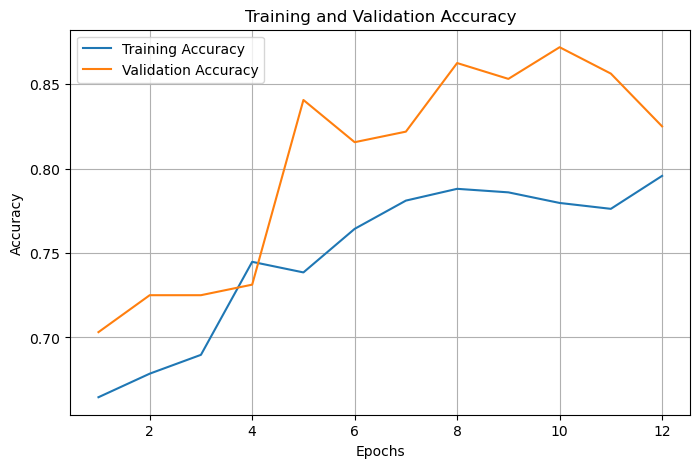

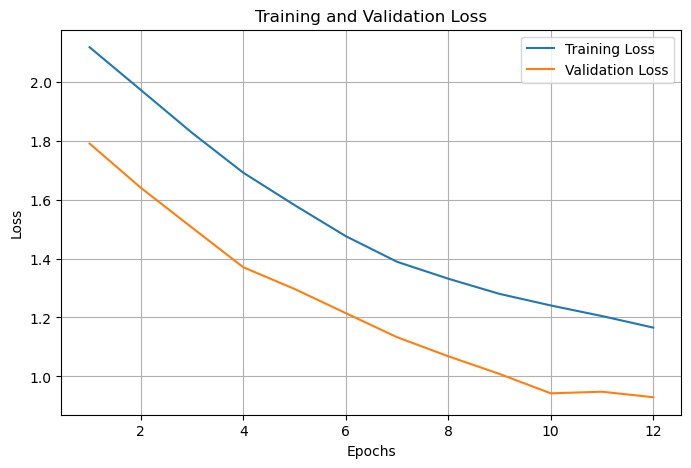

In [16]:
# Extract data from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Get prediction
# Class names (binary)
class_names = ['Benign', 'Malignant']


y_true = []
y_pred = []

# Choose a threshold
threshold = 0.5

# Loop through the validation/test dataset
for images, labels in validation_dataset:
    preds = model.predict(images)

    preds_labels = (preds > threshold).astype(int)

    y_true.extend(labels.numpy())
    y_pred.extend(preds_labels.flatten())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 679ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step



Classification Report:
              precision    recall  f1-score   support

      Benign       0.71      0.68      0.69        97
   Malignant       0.86      0.88      0.87       223

    accuracy                           0.82       320
   macro avg       0.79      0.78      0.78       320
weighted avg       0.82      0.82      0.82       320



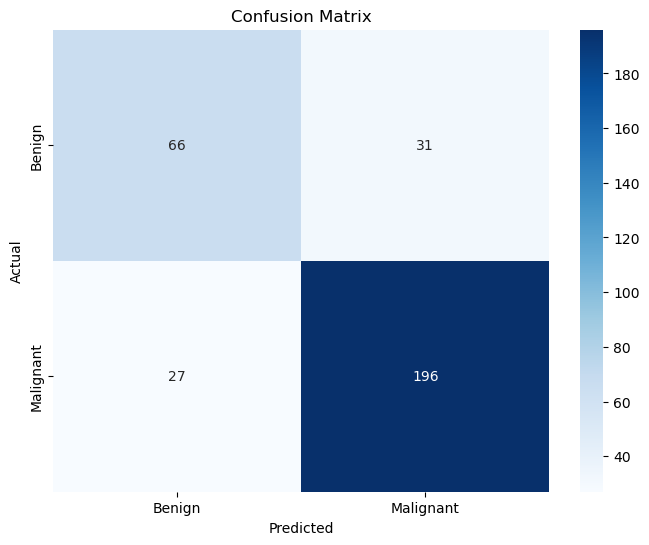

In [19]:
import seaborn as sns

# Classification Report 
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix 
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig("Confusion_matrix.png", bbox_inches="tight")
plt.show()

## **Observations**
* The CNN model demostrates a strong overall performance, achieving 82% accuracy with a strong focus on identifying malignant cases, aligning with
our clinical priority of minimizing false negatives.
* Malignant prediction are highly reliable with 86% Recall, indicating the model correctly identifies majority of cancerous images.
* An F1 score of 87%  shows a balanced learning across classes despite the dataset imbalance.

## **TRANSFER LEARNING**

### **MobileNetV2**

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers 

# Load the pretrained MobileNetV2 model without the top classification layer 
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
# Freeze the base model to prevent its weight from being updated during training
base_model.trainable = False

# Build a full model by stacking custom layers on top of the base model
model_2 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),                    # Converts 2D feature maps to 1D feature vector
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),                                # Dropout for regularization to reduce overfitting
    layers.Dense(1, activation='sigmoid') 
])

model_2.summary()

In [ ]:
# Compile the model
model_2.compile(
    optimizer = 'Adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy', 'precision', 'Recall']
)
    

In [ ]:
# Earlstopping to prevent overfitting
Early_stop = EarlyStopping(
    monitor='val_Recall',
    patience=4,
    restore_best_weights=True
)

Early_stop = EarlyStopping(
    monitor='val_precision',
    patience=4,
    restore_best_weights=True
)

In [ ]:
# Prefetch the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset_augmented = train_dataset_augmented.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Train the model
history = model_2.fit(
    train_dataset_augmented,
    validation_data=validation_dataset,
    epochs=20,
    class_weight= class_weights,
    callbacks=[early_stop]
)

In [ ]:
# Get the model prediction on test set
y_true_2 = []
y_pred_2 = []

for images, labels in validation_dataset:
    # model prediction
    pred_2=model_2.predict(images)
    
    # Convert probabilities to class labels (0 or 1)
    pred_labels = (pred_2 > 0.5).astype(int).flatten()
    
    # Collect true labels and predicted labels
    y_true_2.extend(labels.numpy().astype(int))
    y_pred_2.extend(pred_labels)

y_true_2 = np.array(y_true_2)
y_pred_2 = np.array(y_pred_2)
    

In [ ]:
# Classification Report 
print("\nClassification Report:")
print(classification_report(y_true_2, y_pred_2, target_names=class_names))

# Confusion Matrix 
cm = confusion_matrix(y_true_2, y_pred_2)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## **CNN and MobileNetV2 Performance Comparisons**

#### **Performance on Malignant Class**
* **CNN**:
Precision: 0.88,
Recall: 0.86,
F1_Score: 0.87

* **MobileNetV2**:
Precision: 0.95,
Recall: 0.69,
F1_Score: 0.80

For medical use(Malignant Detection Priority) CNN performed better
* It finds more malignant cases (higher recall) compared to MobileNetV2, reducing the false negatives.


In [ ]:
# Save the cnn model
model.save("cnn_model.keras")